### The web traffic is basically the number of sessions in a given time frame, and it varies a lot with respect to what time of the day it is, what day of the week it is, and so on, and how much web traffic of platform can withstand depends on the size of the servers that are supporting the platform.

* If the traffic is more than what the servers can handle, the website might show this **404 error**, which is something we don’t want to happen. It will make the visitors go away.

* One solution to this problem is to increase the number of servers. However, the downside of the solution is the cause can go up, which is again undesirable. So, what is the solution?

#### You can dynamically a lot of servers based on the historical visitor’s volume data or based on the historical web traffic data. And that brings us to the data science problem, which is basically forecasting the web traffic or a number of sessions based on the historical data.


In [1]:
import pandas as pd
import numpy as np

In [2]:
data=pd.read_csv('webtraffic.csv')
data.shape
data.head()

,Hour Index,Sessions
0,0,1418159421
1,1,1113769116
2,2,919158921
3,3,822352824
4,4,735526737


## Data Exploration

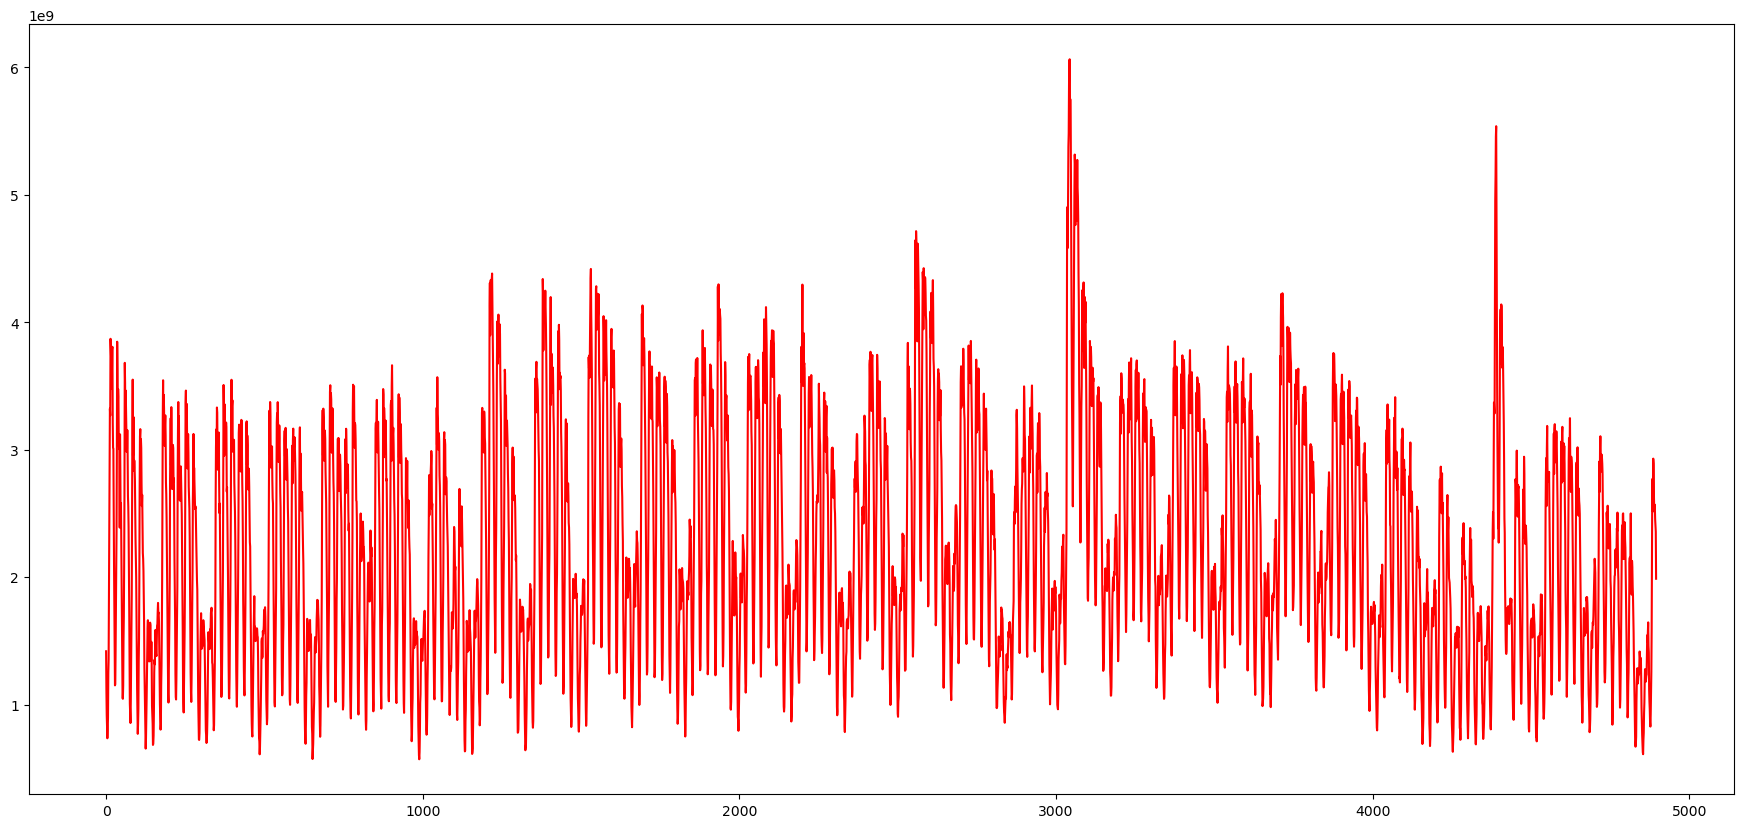

In [3]:
import matplotlib.pyplot as plt
sessions = data['Sessions'].values

ar = np.arange(len(sessions))
plt.figure(figsize=(22,10))
plt.plot(ar, sessions,'r')
plt.show()

Each point of this curve is an early session count and you can see there are some repeating patterns throughout the time series.

The traffic volume comes down, after almost equal intervals of time. Apart from that, there are a couple of spikes as well in the traffic, In this plot.

#### Let’s explore this data, at a more granular level, we can use the below code and replace the entire time series, with a subset of it.

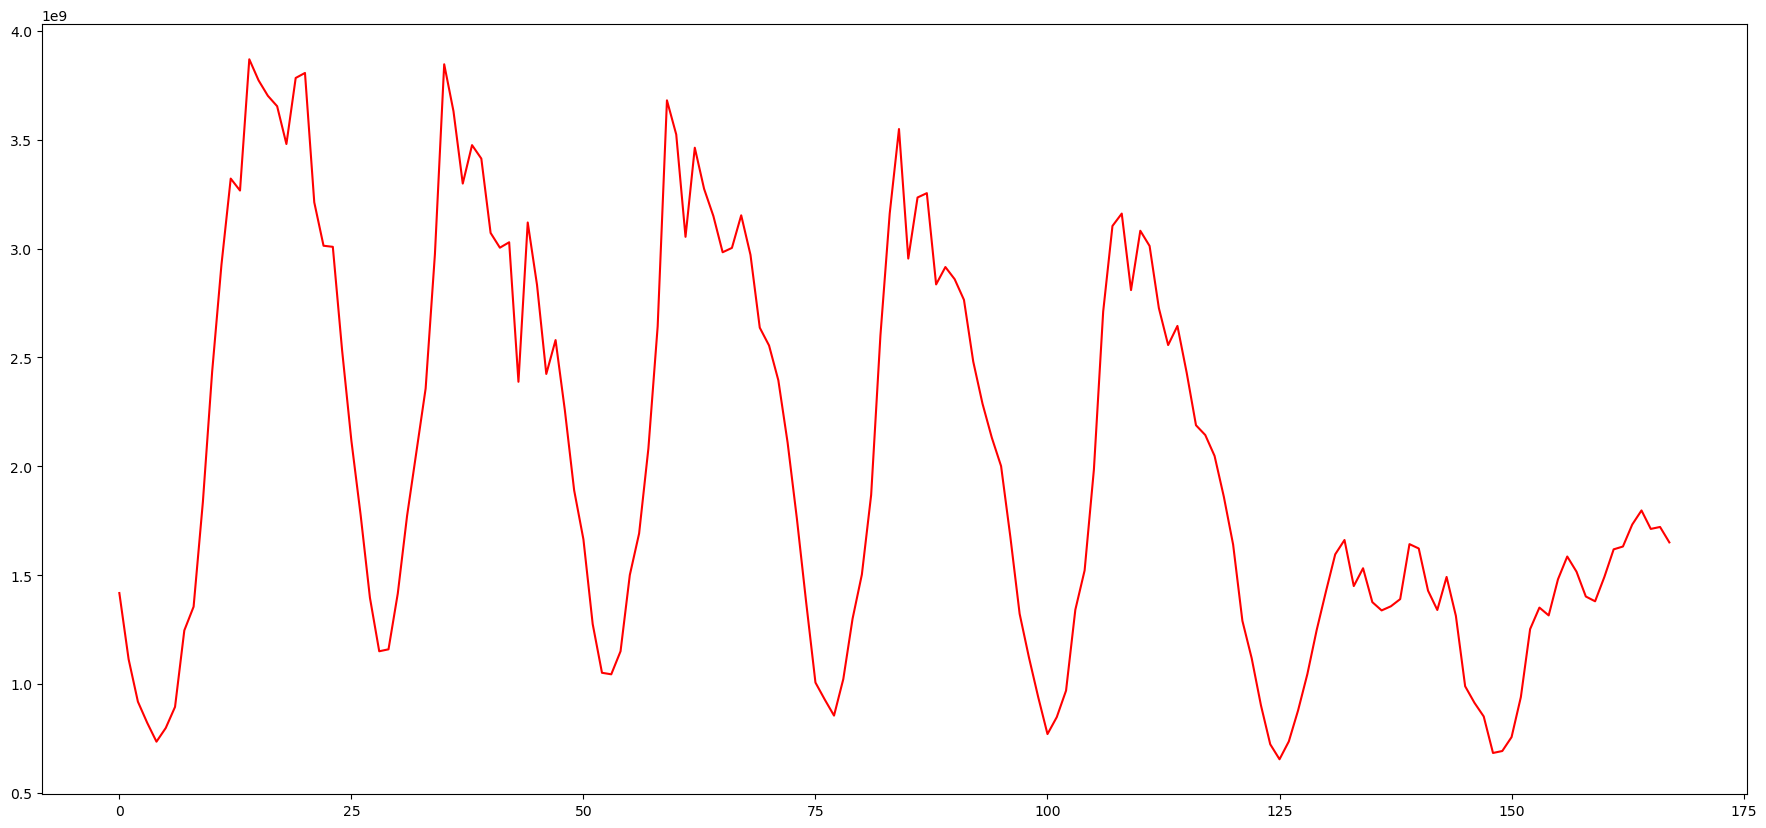

In [4]:
#first week web traffic
sample = sessions[:168]
ar = np.arange(len(sample))
plt.figure(figsize=(22,10))
plt.plot(ar, sample,'r')
plt.show()

#### Here we are plotting the first week’s data only, now the repeating pattern can be seen more clearly, and these dips in the plot in web traffic are may be occurring once every 24 hours. So clearly there are two instances of time in a day, when we have a huge traffic volume, like during a few times and when we have a modest level of traffic on the website. 

Moving on now let’s prepare the data for model training, here we will create input sequences, from the block traffic data. Let’s say this is a time series. Each cell would have some number or value. Let’s create sequences of length five, so the first five observations, will form the first sequence, and the sixth observation, this one will be treated as the target.

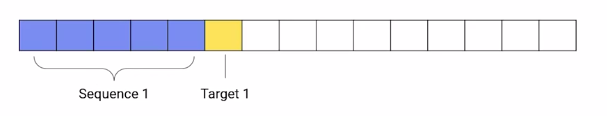

The second sequence will start from the second element, till the sixth element and the target will be the seventh element.
Now the subsequent sequences will be extracted, by moving this window, one step at a time.

In [5]:
def prepare_data(seq,num):
    x=[]
    y=[]

    for i in range(0,(len(seq)-num),1):
        input_ = seq[i:i+num]
        output  = seq[i+num]
        x.append(input_)
        y.append(output)
    
    return np.array(x), np.array(y)

In this function, prepare_data. We are using the same technique to create sequences from time-series data. We have specified the sequence length of one week or 168 hours.Now here we are calling this function to create sequences. The sequence length we have specified is 168 hours and that is equivalent to one week. So we are creating sequences of one week, as our input sequences. Now the number of sequences are well over 4700.

In [6]:
num=168
x,y= prepare_data(sessions,num)
print(len(x))

4728


In [7]:
ind = int(0.9 * len(x))

x_tr = x[:ind]
y_tr = y[:ind]

x_val=x[ind:]
y_val=y[ind:]

In [8]:
from sklearn.preprocessing import StandardScaler

#normalize the inputs
x_scaler= StandardScaler()
x_tr = x_scaler.fit_transform(x_tr)
x_val= x_scaler.transform(x_val)

#reshaping the output for normalization
y_tr=y_tr.reshape(len(y_tr),1)
y_val=y_val.reshape(len(y_val),1)

#normalize the output
y_scaler=StandardScaler()
y_tr = y_scaler.fit_transform(y_tr)[:,0]
y_val = y_scaler.transform(y_val)[:,0]

After that, we are reshaping the data from two dimensional to 3 dimensional.The first dimension of our data is the number of sequences, and the second dimension is the number of elements in the sequences. But LSTM layer accepts only three-dimensional data.

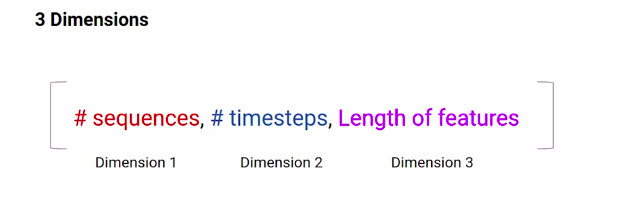

These three dimensions are the number of sequences number of time steps and the length of the features. So third dimension is the length of the vectors of the sequence elements.

Let’s say I have five elements in my sequence and each of these elements has a vector length of 10. So this third dimension will become 10. If you can recall in the case of the auto-tagging projects the length of the sequence elements was nothing but the length of the word embeddings.

However in this dataset, the sequence elements are real number values and therefore the feature length is just one, hence we would reshape both the training set and the validation set


In [9]:
#reshaping input data from 2D to 3D 
x_tr= x_tr.reshape(x_tr.shape[0],x_tr.shape[1],1)
x_val= x_val.reshape(x_val.shape[0],x_val.shape[1],1)
print(x_tr.shape)

(4255, 168, 1)


## Model Building

In [10]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from tensorflow import keras

# define model
model =  Sequential()
model.add(LSTM(128,input_shape=(168,1)))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='linear'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,881
Trainable params: 74,881
Non-trainable params: 0
_________________________________________________________________


#### Have a look at the activation at the final layer ->It is linear. This is because we have to predict a continuous value and not some class tag or category as it is a regression problem and not a classification problem. Other than that we are using a single layer of LSTM here and the input shape is 168 that is one week.The number of train parameters is just around 74000.

In [12]:
# Define the optimizer and loss
model.compile(loss='mse',optimizer='adam')

#Define the callback to save the best model during the training
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss',
        verbose=1, save_best_only=True, mode='min')

# Train the model for 30 epochs with batch size of 32:
history=model.fit(x_tr, y_tr ,epochs=30, batch_size=32, 
           validation_data=(x_val,y_val), callbacks=[mc])

Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 0.1438
Epoch 1: val_loss improved from inf to 0.03401, saving model to best_model.hdf5
133/133 [==============================] - 13s 78ms/step - loss: 0.1438 - val_loss: 0.0340
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 0.0409
Epoch 2: val_loss improved from 0.03401 to 0.02600, saving model to best_model.hdf5
133/133 [==============================] - 10s 77ms/step - loss: 0.0409 - val_loss: 0.0260
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 0.0373
Epoch 3: val_loss improved from 0.02600 to 0.02411, saving model to best_model.hdf5
133/133 [==============================] - 11s 85ms/step - loss: 0.0373 - val_loss: 0.0241
Epoch 4/30
133/133 [==============================] - ETA: 0s - loss: 0.0325
Epoch 4: val_loss did not improve from 0.02411
133/133 [==============================] - 11s 86ms/step - loss: 0.0325 - val_loss: 0.0306
Epoch 5/30
133/133 [=============

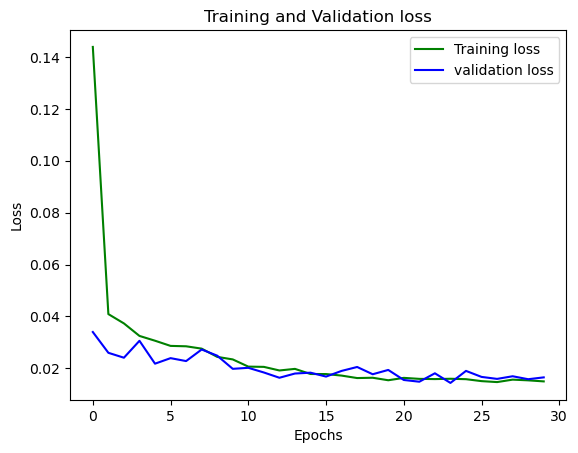

In [13]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

epochs = range(0,30)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* Load the weights of the best model prior to predictions. 
* Now here we will use the mean squared error and we are using model checkpoint again to save the best model weight.
* Finally, the model training starts and moving on the evaluation starts here and moving on to the evaluation part, the mean squared error for the validation data is just 0.015. Evaluate the performance of the model on the validation data.Now, whenever we are working on a project it is always a good practice to have a baseline model, just to have an idea of how good your model is with respect to the baseline predictions.

In [14]:
model.load_weights('best_model.hdf5')

In [15]:
mse = model.evaluate(x_val,y_val)
print("Mean Square Error:",mse)

15/15 [==============================] - 0s 30ms/step - loss: 0.0144
Mean Square Error: 0.01439599972218275


### Baseline Model with Forecasting

So here we are using a simple moving average as the baseline model. So what we will do, we will take a sequence and its length is the same 168 elements. And then we take average this sequence and we compare this average with the target value.

In [16]:
# build a simple moving average model
def compute_moving_average(data):
    pred=[]
    for i in data:
        avg=np.sum(i)/len(i)
        pred.append(avg)
    return np.array(pred)

So this function computes the average of the input sequences and over here we are extracting the predictions.Now we calculate the mean squared error for this model. On the same validation data, we get a score of 0.554 which is way higher than this previous error.

In [17]:
# reshape the data
x_reshaped = x_val.reshape(-1,168)

# get predictions
y_pred = compute_moving_average(x_reshaped)

# evaluate the performance of model on the validation data
mse = np.sum ( (y_val - y_pred) **2 ) / (len(y_val))
print("Mean square of error:- ",mse)

Mean square of error:-  0.5546025834434455


### So our LSTM based model has done exceptionally well as compared to the baseline model,

### Web Traffic Forecasting

Now moving on to forecasting. These are the steps that we will follow:-

* first, initialize an array with weeks data,

* Predict the next hour traffic volume

* Append the predicted value at the end of the array ‘data

* Skip the first element of the array ‘data’

* Repeating steps, from the second step till the fourth step for the specified number of iterations.

This is how we can forecasting for any number of hours in future. This function forecast performs the steps just discuss and it returns the predicted sequence of numbers.

In [18]:
def forecast(x_val, no_of_pred, ind):
    predictions=[]

    #intialize the array with a weeks data
    temp=x_val[ind]

    for i in range(no_of_pred):

        #predict for the next hour
        pred=model.predict(temp.reshape(1,-1,1))[0][0]

        #append the prediction as the last element of array
        temp = np.insert(temp,len(temp),pred)
        predictions.append(pred)

        #ignore the first element of array
        temp = temp[1:]

    return predictions

It’s time to forecast the traffic for the next 24 hours based on the previous week data.

In [19]:
no_of_pred =24
ind=72
y_pred= np.array(forecast(x_val,no_of_pred,ind)).reshape(-1, 1)
y_true = np.array(y_val[ind:ind+(no_of_pred)]).reshape(-1, 1)

# Lets convert back the normalized values to the original dimensional space
y_true= y_scaler.inverse_transform(y_true)
y_pred= y_scaler.inverse_transform(y_pred)



1/1 [==============================] - 0s 42ms/step


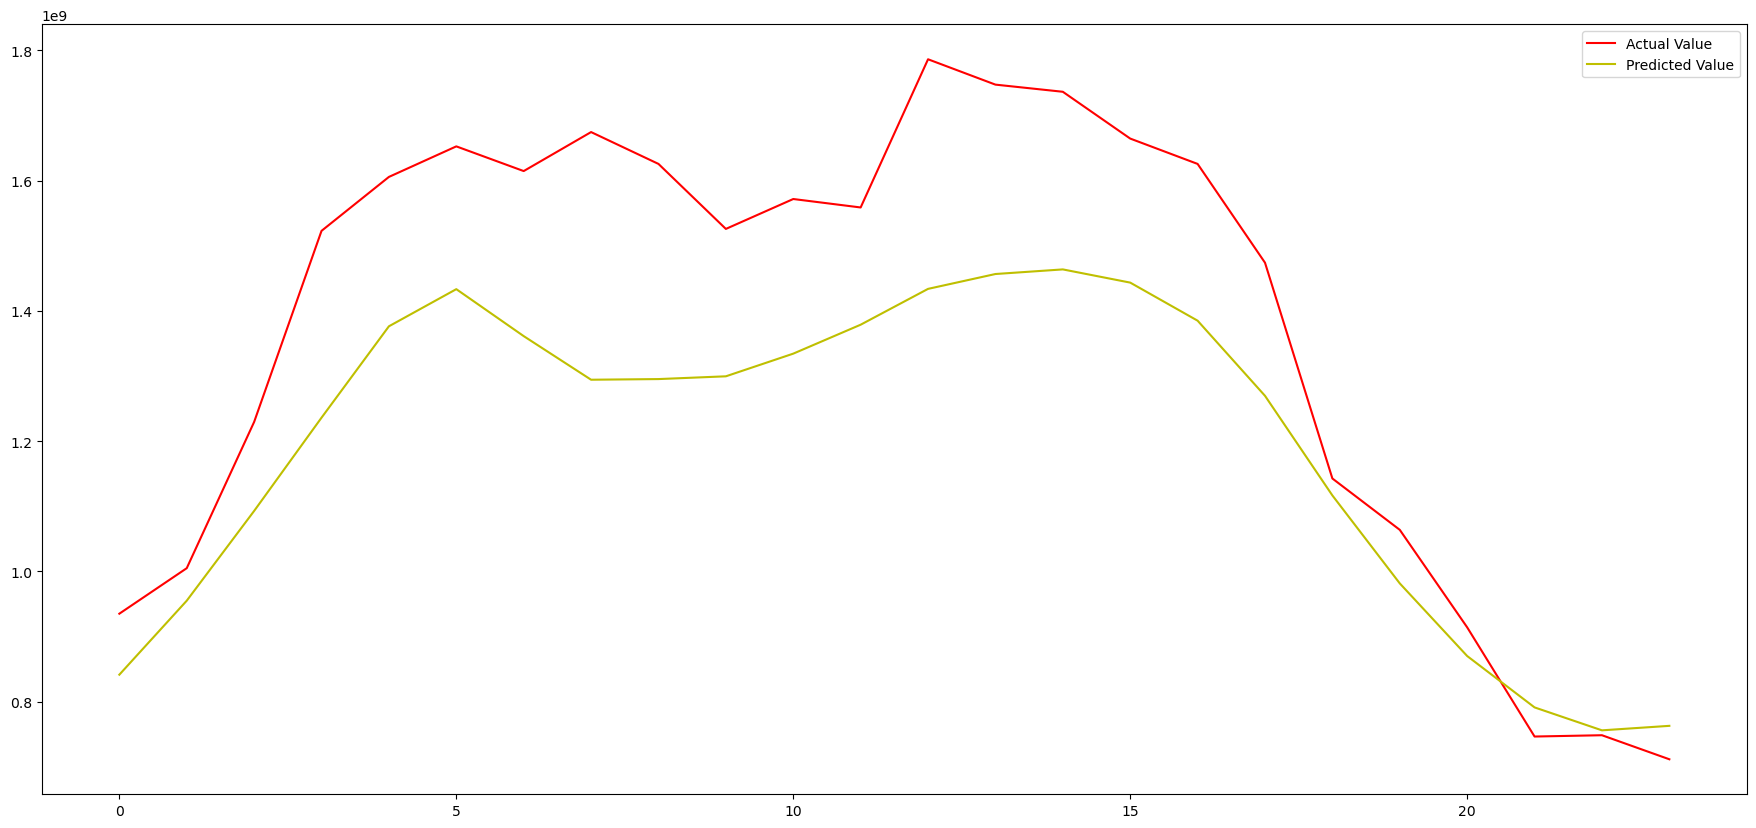

In [20]:
def plot(y_true,y_pred):
    ar = np.arange(len(y_true))
    plt.figure(figsize=(22,10))
    plt.plot(ar, y_true,'r',label="Actual Value")
    plt.plot(ar, y_pred,'y',label="Predicted Value")
    plt.legend(loc="upper right")
    plt.show()

plot(y_true,y_pred)


#### This red curve is the actual value and this yellow curve are the predicted values both are pretty much close to each other.

#### Similarly, we can use a CNN based model in place of LSTM to perform the same task. Let’s see how it is done.
-----------------
-----------------

### CNN Model with Forecasting

Now here we are using Conv1D layers in the model architecture. And these layers are followed by a flattening layer. This layer converts the input to a One Dimensional array, which is then passed on to this set of dense layers.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

model= Sequential()
model.add(Conv1D(64, 3, padding='same', activation='relu',input_shape=(num,1)))
model.add(Conv1D(32, 5, padding='same', activation='relu',input_shape=(num,1)))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 168, 64)           256       
                                                                 
 conv1d_1 (Conv1D)           (None, 168, 32)           10272     
                                                                 
 flatten (Flatten)           (None, 5376)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                344128    
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 354,721
Trainable params: 354,721
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define the optimizer and loss:
model.compile(loss='mse',optimizer='adam')

# Define the callback to save the best model during the training
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1,
         save_best_only=True, mode='min')

# Train the model for 30 epochs with batch size of 32:
history=model.fit(x_tr, y_tr ,epochs=30, batch_size=32, validation_data=(x_val,y_val),
            callbacks=[mc])

Epoch 1/30
132/133 [============================>.] - ETA: 0s - loss: 0.0969
Epoch 1: val_loss improved from inf to 0.03883, saving model to best_model.hdf5
133/133 [==============================] - 7s 46ms/step - loss: 0.0964 - val_loss: 0.0388
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 0.0257
Epoch 2: val_loss improved from 0.03883 to 0.01956, saving model to best_model.hdf5
133/133 [==============================] - 10s 72ms/step - loss: 0.0257 - val_loss: 0.0196
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 0.0181
Epoch 3: val_loss improved from 0.01956 to 0.01686, saving model to best_model.hdf5
133/133 [==============================] - 10s 72ms/step - loss: 0.0181 - val_loss: 0.0169
Epoch 4/30
133/133 [==============================] - ETA: 0s - loss: 0.0153
Epoch 4: val_loss did not improve from 0.01686
133/133 [==============================] - 10s 76ms/step - loss: 0.0153 - val_loss: 0.0243
Epoch 5/30
132/133 [==============

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']

epochs = range(0,30)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Load the weights of the best model prior to predictions.
model.load_weights('best_model.hdf5')

# Let’s check out the performance of this model on the validation set. 
# Evaluate the performance of a model on the validation data.
mse = model.evaluate(x_val,y_val)
print("Mean Square Error:",mse)

#### The mean squared error has improved the width from 0.015 to 0.013.

### Comparison with the baseline model

Now let’s compare this performance with the baseline model.

In [ ]:
#build a simple model
def compute_moving_average(data):
    pred=[]
    for i in data:
        avg=np.sum(i)/len(i)
        pred.append(avg)
    return np.array(pred)

x_reshaped = x_val.reshape(-1,168)
y_pred = compute_moving_average(x_reshaped)

mse = np.sum ( (y_val - y_pred) **2 ) / (len(y_val))
print("Mean Square Error:",mse)

#### The baseline score was 0.55. So our CNN based model is also much better than the baseline model.

### Forecasting

Now let’s see how well it forecast the web traffic for a period of 24 hours.

In [ ]:
def forecast(x_val, no_of_pred, ind):
    predictions=[]

    #intialize the array with previous weeks data  
    temp=x_val[ind]

    for i in range(no_of_pred):

        #predict for the next hour
        pred=model.predict(temp.reshape(1,-1,1))[0][0]

        #append the prediction as the last element of array
        temp = np.insert(temp,len(temp),pred)
        predictions.append(pred)

        #ignore the first element of array
        temp = temp[1:]

    return predictions

In [ ]:
no_of_pred =24
ind=72

y_pred= np.array(forecast(x_val,no_of_pred,ind)).reshape(-1, 1)
y_true = np.array(y_val[ind:ind+(no_of_pred)]).reshape(-1, 1)

y_true= y_scaler.inverse_transform(y_true)
y_pred= y_scaler.inverse_transform(y_pred)

In [ ]:
def plot(y_true,y_pred):
    ar = np.arange(len(y_true))
    plt.figure(figsize=(22,10))
    plt.plot(ar, y_true,'r',label="Actual Value")
    plt.plot(ar, y_pred,'y',label="Predicted Value")
    plt.legend(loc="upper right")
    plt.show()

In [ ]:
plot(y_true,y_pred)

## THANKYOU